# Quantum walk on complex network

## What this notebook does

Quantum walks are often used as building blocks for graph exploration / graph-based quantum algorithms.

This notebook simulates a **discrete-time quantum walk** on a **complex network (graph)**.

- The **graph** is a set of nodes connected by edges (we generate it with NetworkX).
- The **walker position** is stored in a quantum register `x`.
- A second register `y` acts like a **coin / direction / neighbor-choice register**.
- Each step of the walk applies:
  1. **Coin operator** (mix amplitudes in a way that depends on the current node’s neighbors)
  2. **Shift operator** (moves the walker according to the coin register)

At the end we **measure** the position register and plot a **probability distribution over nodes**.


> Note: This is a *discrete-time* walk (coin + shift), not a continuous-time walk.


## Imports and dependencies


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from classiq import *

## Step 1 — Create a “complex network” (the graph)

Here we generate a small graph `G`. The notebook currently uses a **Watts–Strogatz** model, which is a classic “small-world” network model:
- it has high clustering (like regular lattices),
- and short path lengths (like random graphs).

You can switch to other models by uncommenting the alternatives:
- Erdős–Rényi (random graph)
- Barabási–Albert (scale-free graph)

Then we draw the graph so we can visually connect the output distribution to the network structure.


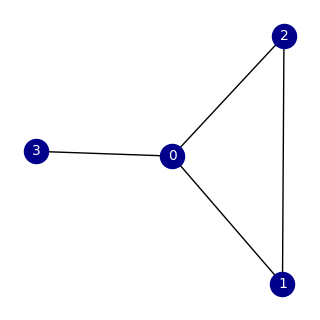

In [2]:
G = nx.connected_watts_strogatz_graph(n=4, k=2, p=0.2, tries=100, seed=312)
# G = nx.erdos_renyi_graph(n=4, p=0.3, seed=42)
# G = nx.barabasi_albert_graph(n=8,m=2)
plt.figure(figsize=(3, 3))
nx.draw(
    G,
    with_labels=True,
    node_color="darkblue",
    edge_color="black",
    font_color="white",
    font_size=10,
)

## Step 2 — Decide how many qubits are needed for the position register

If the graph has `N` nodes, we need enough qubits to encode node indices in binary.

- `N = len(G.nodes())`
- `num_qubits = ceil(log2(N))`

That means the quantum register `x` can represent `2**num_qubits` = `N`.


In [3]:
N = len(G.nodes())
num_qubits = int(np.ceil(np.log2(N)))
print("number of nodes=", N, "number of required qubits=", num_qubits)

number of nodes= 4 number of required qubits= 2


## Step 3 — Build “neighbor-aware” probability vectors

A quantum walk on a graph needs a way to represent “where can I go next from node $i$?”.

We create helper functions:
- `get_edges_of_node(G, i)`: returns the neighbors of node `i`.
- `inner_degree(G, num_qubits, i)`: builds a length `2**num_qubits` vector where:
  - entries corresponding to neighbors of `i` are `1`,
  - all others are `0`,
  - then we normalize by the node degree `k` to get a **uniform distribution over neighbors**.

This vector is used to prepare the `y` register so it represents “allowed moves” from the current node.


In [4]:
def get_edges_of_node(G, i):
    return [j for j in G.neighbors(i)]


# DEGREE_LIST = np.zeros(N)
# for i in range(N):
#    DEGREE_LIST[i] = len(get_edges_of_node(G, i))


def inner_degree(G, num_qubits, i):
    l_array = np.zeros(2**num_qubits)
    neighbors_list = get_edges_of_node(G, i)
    k = len(neighbors_list)
    for j in neighbors_list:
        l_array[j] = 1
    return l_array / k

## Step 4 — Define the quantum walk (state prep, coin, shift, and repeated steps)

This cell defines the core quantum logic using Classiq `@qfunc`.

### Registers
- `x`: **position register** (which node the walker is on)
- `y`: **coin / neighbor register** (encodes the neighbor-choice space)

### 4.1 Initial state: `prepare_initial_state(x, y)`
Goal: start with a clean, interpretable state.

1. Prepare `x` in a **uniform superposition over valid nodes**:
   - If `N` is exactly `2**num_qubits`, a Hadamard transform gives uniform superposition automatically.
   - Otherwise, we prepare a custom probability vector that gives equal weight to nodes `0..N-1` and zero to invalid states.

2. Prepare `y` **conditioned on the current node in `x`**:
   For each node `i`, if `x == i`, we prepare `y` using the neighbor distribution vector from `inner_degree(...)`.

So after this, the state is conceptually:
- “uniform over nodes” in `x`,
- and for each node, `y` contains amplitudes only on its neighbors.

### 4.2 Coin operator: `my_coin(x, y)`
A discrete-time quantum walk needs a “coin flip” to mix amplitudes.

Here, the coin depends on the current node:
- If `x == i`, apply a **Grover diffuser** on register `y` corresponding to neighbors of node `i`.
This mixes the neighbor amplitudes in a structured way.

### 4.3 Shift operator: `my_shift(x, y)`
This updates the position based on the coin information.

### 4.4 Repeating steps: `discrete_quantum_walk(time, coin, shift, x, y)`
We apply the pair `(coin, shift)` repeatedly `time` times using `power(time, ...)`.

That is exactly the discrete-time walk loop:
**(coin → shift) × t**


In [5]:
@qfunc
def prepare_initial_state(x: QNum[num_qubits], y: QNum[num_qubits]):
    if N == 2**num_qubits:
        hadamard_transform(x)
    else:
        prob_array = np.ones(2**num_qubits) / N
        prob_array[N : 2**num_qubits] = 0
        inplace_prepare_state(prob_array.tolist(), 0.0, x)
    for i in range(N):
        control(
            x == i,
            lambda: inplace_prepare_state(
                inner_degree(G, num_qubits, i).tolist(), 0.0, y
            ),
        )


@qfunc
def my_coin(x: QNum[num_qubits], y: QNum[num_qubits]):
    for i in range(N):
        control(
            x == i,
            stmt_block=lambda: grover_diffuser(
                lambda y: inplace_prepare_state(
                    inner_degree(G, num_qubits, i).tolist(), 0.0, y
                ),
                y,
            ),
        )


@qfunc
def my_shift(x: QNum[num_qubits], y: QNum[num_qubits]):
    multiswap(x, y)


@qfunc
def discrete_quantum_walk(
    time: CInt,
    coin_qfuncs: QCallable[QNum, QNum],
    shift_qfuncs: QCallable[QNum, QNum],
    x: QNum,
    y: QNum,
):
    power(
        time,
        lambda: (
            coin_qfuncs(x, y),
            shift_qfuncs(x, y),
        ),
    )

## Step 5 — Choose number of steps, build `main`, and synthesize the circuit

### Number of steps
`t` controls how far the quantum walk evolves. More steps usually means:
- wider spreading over the graph,
- more interference patterns,
- sometimes more “structure” in the final distribution (depending on the graph).

### The `main` quantum program
`main(x: Output[QNum[num_qubits]])`:
1. Allocates `x` (position) and `y` (coin).
2. Prepares the initial state.
3. Applies the discrete-time quantum walk for `t` steps.
4. Drops `y` (we only care about measuring the position distribution in `x`).

Finally:
- `synthesize(main)` compiles the high-level program into an executable quantum program.
- `show(qprog)` displays the synthesized result.


In [6]:
# quantum walk steps
t = 3


@qfunc
def main(x: Output[QNum[num_qubits]]):
    y = QNum("y", num_qubits)
    allocate(num_qubits, x)
    allocate(num_qubits, y)
    prepare_initial_state(x, y)
    discrete_quantum_walk(t, my_coin, my_shift, x, y)
    drop(y)


qprog = synthesize(main)
write_qmod(main, decimal_precision=15, name="dt_quantumwalk_complex_network")
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/36q7qOkGDqbMNrOQoLoVHvTZRAo


## Step 6 — Execute and collect results

Here we run the synthesized program and fetch the results.

The key output we care about is the measured distribution of the **position register `x`**:
- each possible node index `x` has a probability,
- these probabilities should sum to ~1 (up to sampling / execution effects).


In [7]:
execution_job = execute(qprog)
result = execution_job.result_value()

## Step 7 — Visualize the probability distribution over nodes

We plot a bar chart:
- **x-axis**: node index (the measured value of the position register `x`)
- **y-axis**: probability of measuring that node

Tip for interpretation:
- Compare “high-probability nodes” to the graph drawing.
- Try changing the graph model or `t` and see how the distribution changes.


<Axes: xlabel='x'>

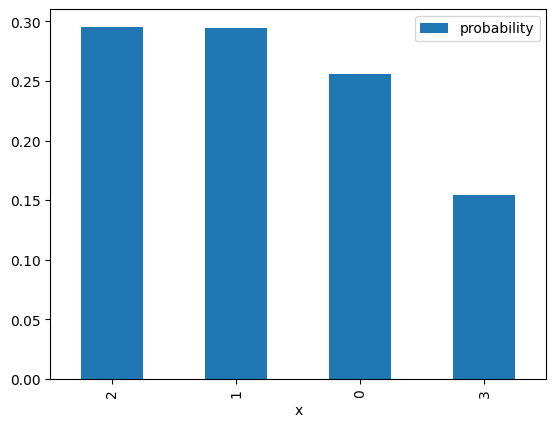

In [8]:
result.dataframe.plot.bar(x="x", y="probability")